# Structured Bayesian Optimisation with Pyro
## Testing performance

Goal: compare performances of standard BO-GP, random GP and SBO-GP strategies to minimize Branin-Hoo and hyperbolic functions with pyro.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.distributions import constraints, transform_to
import torch.optim as optim
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
from pyro.nn import PyroSample, PyroModule
from pyro.infer import autoguide, SVI, Trace_ELBO

In [2]:
print(torch.__version__)
print(pyro.__version__)

1.3.0.post2
1.0.0


### Setting random seed

In [3]:
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

### Minimalistic (S)BO approach

#### Acquisition function

In [4]:
def lower_confidence_bound(model, x, kappa=2):
    """ Lower Confidence Bound (LCB): $\alpha(x)=\mu(x) - \kappa\sigma(x)$ """
    
    mu, variance = model(x)
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2

def expected_improvement(model, x):
    """ Brooks' implementation of expected improvement (EI). """
    
    y_min = model.y.min()
    mu, variance = model(x)
    sigma = variance.sqrt()
    delta = y_min - mu
    EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
    
    return -EI

def acquisition_func(model, x, af='EI'):
    """ Defines acquisition function. """

    if af == "EI":
        return expected_improvement(model, x)
    elif af == "LCB":
        return lower_confidence_bound(model, x)
    else:
        return None

#### Model training

In [5]:
def train(model, num_steps=1000, adam_params={"lr":0.1}):
    """ Trains the semi-parametric model. """
    
    # TODO: check if param store needs to be cleared here.
    pyro.clear_param_store()
    # setup the inference algorithm
    guide = autoguide.AutoMultivariateNormal(model.model)
    optimizer = pyro.optim.Adam(adam_params)
    loss = Trace_ELBO()
    svi = SVI(model.model, guide, optimizer, loss)
    # do gradient steps
    losses = []
    for _ in range(num_steps):
        losses.append(svi.step())
    
    return losses, guide

def train_gp(model, num_steps=1000, adam_params={"lr":0.1}):
    """ Trains the gp model. """
    
    optimizer = torch.optim.Adam(model.parameters(), lr=adam_params['lr'])
    loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
    losses = gp.util.train(model, optimizer, loss_fn, num_steps=num_steps)

    return losses, None

#### Finding new candidates

In [6]:
def find_a_candidate(model, x_init, constr, num_steps=1000, lr=0.1):
    """ Finds new candidate """
    
    def transf_values(values, constr, dims, inv_mode=False):
        """ Transforming (un)constrained variables to (un)constrained domain """
        
        x_tmp = ()
        for i in range(dims):
            if inv_mode:
                x_tmp += (transform_to(constr[i]).inv(values[:, i]), )
            else:
                x_tmp += (transform_to(constr[i])(values[:, i]), )
            
        x = torch.stack(x_tmp, dim=1)
        return x
            
    x_dims = x_init.shape[-1]
    
    x_uncon_init = transf_values(x_init, constr, x_dims, inv_mode=True)
    x_uncon = x_uncon_init.clone().detach().requires_grad_(True)
    
    # unconstrained minimiser 
    # TODO: at the moment we are using torch optimizer, should we change to pyro?
    
    minimizer = optim.Adam([x_uncon], lr=lr)
    
    #minimizer = optim.LBFGS([x_uncon], line_search_fn='strong_wolfe')
    
    def closure():
        minimizer.zero_grad()
        x = transf_values(x_uncon, constr, x_dims)
        y = acquisition_func(model, x)
        autograd.backward(x_uncon, autograd.grad(y, x_uncon))      
        return y
    
    for _ in range(num_steps):
        minimizer.step(closure)
   
    x = transf_values(x_uncon, constr, x_dims)
    
    return x.detach()

In [7]:
def next_x(model, constr, num_candidates=5, num_steps=1000, lr=0.1):
    """ Finds the next best candidate on the acquisition function surface """
    
    candidates = []
    values = []
    
    # start with last step
    x_init = model.X[-1:]
    for i in range(num_candidates):

        x = find_a_candidate(model, x_init, constr, num_steps=num_steps, lr=lr)
        y = acquisition_func(model, x)
    
        candidates.append(x)
        values.append(y)
        
        # a new random attempt initial point
        x_init = torch.stack((
                x[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                x[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
        
    return candidates[argmin]

#### Updating posterior

In [8]:
def update_posterior(model, obj_function, x_new, num_steps=1000, adam_params={"lr":0.1}, 
                    gp_mode=False):
    
    # evaluate f at new point
    bh_y = obj_function(x_new) 
        
    # incorporate new evaluation
    model.X = torch.cat([model.X, x_new]) 
    model.y = torch.cat([model.y, bh_y])
    
    if not gp_mode:
        losses, guide = train(model, num_steps=num_steps, adam_params=adam_params)
    else:
        losses, guide = train_gp(model, num_steps=num_steps, adam_params=adam_params)
    
    return guide

### Helper functions

In [9]:
def plot_obj(obj_function):

    steps = 1000
    strides = 200

    X1 = torch.linspace(const_x1_min, const_x1_max, steps)
    X2 = torch.linspace(const_x2_min, const_x2_max, steps)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    
    Z_mesh = obj_function(torch.stack((X1_mesh.flatten(), X2_mesh.flatten()), dim=1)).reshape(steps, steps)
    plt.contour(
        X1_mesh.detach().numpy(), 
        X2_mesh.detach().numpy(), 
        Z_mesh.detach().numpy(), strides)
    
    plt.colorbar()

In [10]:
def find_best_solution(xmins, target_lms):
    closest_dist = np.inf
    closest_point = None
    
    for xmin in xmins:
        for bh_lm in target_lms:
            dist = np.linalg.norm(xmin-bh_lm)
            if dist < closest_dist: 
                closest_dist = dist
                closest_point = xmin
                
    return closest_point, closest_dist

# Branin-Hoo example

In [11]:
const_x1_min = -5
const_x1_max = 10

const_x2_min = 0
const_x2_max = 15

# Creating constraints
constr = [
    constraints.interval(const_x1_min, const_x1_max),
    constraints.interval(const_x2_min, const_x2_max)
]

def branin_hoo(x):
    """ Compute Branin-Hoo function for fixed constants """
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    x1 = x[...,0]
    x2 = x[...,1]
    return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*torch.cos(x1) + s


branin_hoo_lms_np = np.stack(
    (np.array([-math.pi, math.pi, 9.42478]), 
     np.array([12.275, 2.275, 2.475])), axis=1)

# Checking LMs
branin_hoo_lms = torch.stack(
    (torch.tensor([-math.pi, math.pi, 9.42478]), 
     torch.tensor([12.275, 2.275, 2.475])), dim=1)

assert np.allclose(branin_hoo(branin_hoo_lms).numpy(),
        np.array([0.397887, 0.397887, 0.397887], dtype=np.float32), rtol=1e-6)

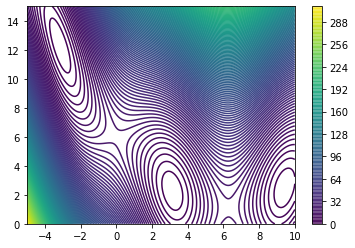

In [12]:
plot_obj(branin_hoo)

In [16]:
set_random_seed(123)

## Parameters

In [17]:
# Training points
N_train = 10
X_train = torch.rand(N_train, 2)*15 + torch.FloatTensor([const_x1_min, const_x2_min])
y_train = branin_hoo(X_train)

# Optimiser parameters
adam_num_steps = 1000
adam_params={"lr": 0.1}

num_candidates = 10

bo_steps = 20

num_tests = 20

## BO approach

In [18]:
bo_tests_search_points = []

for test_i in range(num_tests):
    try:
        print("TEST: ", test_i+1)

        pyro.clear_param_store()

        gp_model_svi = gp.models.GPRegression(X_train, y_train, 
                                              gp.kernels.Matern52(input_dim=X_train.shape[1], 
                                                                  lengthscale=100*torch.ones(X_train.shape[1])))

        # Set priors
        gp_model_svi.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(3, 1).expand([2]).to_event())
        gp_model_svi.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(5, 2))
        gp_model_svi.noise = pyro.nn.PyroSample(dist.LogNormal(0, 1))

        # Set guides
        gp_model_svi.kernel.autoguide("lengthscale", dist.Normal)
        gp_model_svi.kernel.autoguide("variance", dist.Normal)
        gp_model_svi.autoguide("noise", dist.Normal)

        # optimise
        losses, _ = train_gp(gp_model_svi, num_steps=adam_num_steps, adam_params=adam_params)

        xmins = np.zeros([bo_steps, 2], np.float32)

        for i in range(bo_steps):
            xmin = next_x(gp_model_svi, constr, num_candidates=num_candidates, num_steps=adam_num_steps)

            update_posterior(gp_model_svi, branin_hoo, xmin, 
                             num_steps=adam_num_steps, adam_params=adam_params, gp_mode=True)

            xmins[i] = xmin.detach().numpy()

            closest_point, closest_dist = find_best_solution([xmins[i]], branin_hoo_lms_np)
            print("  BO STEP: ", i+1, "xmin:", xmins[i], " distance: ", closest_dist)

        # saving results for the run
        np.savetxt("pyro_results/pyro_bo_%d.out" % (test_i), xmins, delimiter=',')

        closest_point, closest_dist = find_best_solution(xmins, branin_hoo_lms_np)
        print("  Best candidate: ", closest_point, " distance: ", closest_dist)

        bo_tests_search_points.append(xmins)
    except:
        continue


TEST:  1
  BO STEP:  1 xmin: [9.927504   0.01175216]  distance:  2.514024842742145
  BO STEP:  2 xmin: [ 9.997484 14.992119]  distance:  12.530213647406365
  BO STEP:  3 xmin: [4.4871311e+00 2.9869182e-03]  distance:  2.6405524431727665
  BO STEP:  4 xmin: [5.665555 4.476292]  distance:  3.349040606487667
  BO STEP:  5 xmin: [-3.133821 14.99865 ]  distance:  2.7236606849217027
  BO STEP:  6 xmin: [ 2.117208 14.999884]  distance:  5.922835070447907
  BO STEP:  7 xmin: [2.3304515 2.9970307]  distance:  1.0859458421206376
  BO STEP:  8 xmin: [9.998664  3.9514353]  distance:  1.5840467195375205
  BO STEP:  9 xmin: [9.998623  7.9225383]  distance:  5.477679160437907
  BO STEP:  10 xmin: [7.51458    0.00815232]  distance:  3.119968326846718
  BO STEP:  11 xmin: [1.9533019 0.0021184]  distance:  2.5647661985020194
  BO STEP:  12 xmin: [8.882583 3.476767]  distance:  1.1390852467784405
  BO STEP:  13 xmin: [3.563037  2.3760965]  distance:  0.43340024023611523
  BO STEP:  14 xmin: [9.990413  2.

  BO STEP:  7 xmin: [-4.981145 10.774741]  distance:  2.373758419599738
  BO STEP:  8 xmin: [7.7173100e+00 1.5211864e-04]  distance:  3.0067134884217954
  BO STEP:  9 xmin: [2.74445   3.8120453]  distance:  1.5875234102798657
  BO STEP:  10 xmin: [3.2284088 2.1705472]  distance:  0.1358212915590344
  BO STEP:  11 xmin: [ 4.685192 14.999068]  distance:  8.287285900272762
  BO STEP:  12 xmin: [9.999297  3.3670826]  distance:  1.061075541259513
  BO STEP:  13 xmin: [-3.1120381 12.654526 ]  distance:  0.38067475571637577
  BO STEP:  14 xmin: [8.952982  2.6697288]  distance:  0.510404437148364
  BO STEP:  15 xmin: [-4.4023585 14.999476 ]  distance:  3.0020497052724484
  BO STEP:  16 xmin: [9.997611  6.1270075]  distance:  3.6966598536316524
  BO STEP:  17 xmin: [2.741167  2.5497432]  distance:  0.48561760851189145
  BO STEP:  18 xmin: [3.3095865 2.646256 ]  distance:  0.40749593382097965
  BO STEP:  19 xmin: [-3.0591393 12.028207 ]  distance:  0.2602026798128129
TEST:  8
  BO STEP:  1 xmin:

  BO STEP:  14 xmin: [2.7444286 3.1418624]  distance:  0.9535143760569392
  BO STEP:  15 xmin: [3.2461176 1.6879332]  distance:  0.5962993230601208
  BO STEP:  16 xmin: [-3.1684134 11.534838 ]  distance:  0.7406480602113612
  BO STEP:  17 xmin: [-4.9996486 14.99917  ]  distance:  3.2974953576770827
  BO STEP:  18 xmin: [-2.8719618 12.059986 ]  distance:  0.34486482987262385
  BO STEP:  19 xmin: [9.069668  2.7742321]  distance:  0.4643754323600364
  BO STEP:  20 xmin: [9.490486  2.8025231]  distance:  0.3340489518013767
  Best candidate:  [9.490486  2.8025231]  distance:  0.3340489518013767
TEST:  13
  BO STEP:  1 xmin: [9.982199  0.0647711]  distance:  2.4738469981439275
  BO STEP:  2 xmin: [4.7762575e+00 1.4668229e-04]  distance:  2.801265218805253
  BO STEP:  3 xmin: [ 9.992966 14.998321]  distance:  12.536203305839322
  BO STEP:  4 xmin: [7.19011   4.5702057]  distance:  3.063272100637005
  BO STEP:  5 xmin: [-4.9973764 10.737354 ]  distance:  2.410038969355115
  BO STEP:  6 xmin: [

  BO STEP:  19 xmin: [3.184167  2.3068292]  distance:  0.053156994187512976
  BO STEP:  20 xmin: [8.602107  1.1104342]  distance:  1.5933708538551454
  Best candidate:  [3.184167  2.3068292]  distance:  0.053156994187512976
TEST:  18
  BO STEP:  1 xmin: [9.911383   0.01106773]  distance:  2.511522322104057
  BO STEP:  2 xmin: [ 9.986849 14.993353]  distance:  12.530964865081959
  BO STEP:  3 xmin: [4.556511   0.00988731]  distance:  2.670716989171533
  BO STEP:  4 xmin: [6.103016 4.680514]  distance:  3.8153013730516716
  BO STEP:  5 xmin: [1.755053   0.00949421]  distance:  2.656126613969134
  BO STEP:  6 xmin: [2.7019954 3.8474357]  distance:  1.6327277299770837
  BO STEP:  7 xmin: [-4.9949207 11.11126  ]  distance:  2.1884046208908106
  BO STEP:  8 xmin: [-2.5871253 14.998406 ]  distance:  2.7792762582910164
  BO STEP:  9 xmin: [9.999351  3.8290741]  distance:  1.4709344318567668
  BO STEP:  10 xmin: [3.5844336 2.760527 ]  distance:  0.6571487128285092
  BO STEP:  11 xmin: [9.999483

## SBO approach

In [ ]:
# Matching the parametric function used in BOAT
class ParametricMeanFn(PyroModule):
    
    def __init__(self):
        super().__init__()
        self.alpha = PyroSample(dist.Uniform(0, 20))
        self.beta = PyroSample(dist.Uniform(0, 20))
        self.gamma = PyroSample(dist.Uniform(0, 20))
        
    def forward(self, X):
        x1 = X[...,0]
        x2 = X[...,1]
        return self.alpha*torch.cos(x1) + self.beta*torch.pow(x1, 4) + \
            torch.pow(x2, 2) + self.gamma

# Semi parametric model as implemented by Brooks
class SemiParametricModel(PyroModule):

    def __init__(self, X, y, parametric_mean):
        """ Defines a semi-parametric model, where the `parametric_mean` is a `PyroModule` """
        super().__init__()
        self.parametric_mean = parametric_mean
        self.X = X
        self.y = y
        
        # Define GP (to be used for residual)
        self.kernel = gp.kernels.Matern52(input_dim=X.shape[1], lengthscale=100*torch.ones(X.shape[1]))
        self.gp = gp.models.GPRegression(X, y, self.kernel) 
        
        self.gp.kernel.lengthscale = PyroSample(dist.LogNormal(3, 1).expand([2]).to_event())
        self.gp.kernel.variance = PyroSample(dist.LogNormal(5, 2))
        self.gp.noise = PyroSample(dist.LogNormal(0, 1))

    @pyro.nn.pyro_method
    def model(self):
        # Model definition code: explicitly subtract out the parametric mean, then call gp.model
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        return self.gp.model()
        
    def forward(self, X):
        ''' Predict on new data points '''
        # reset "data" of GP to reflect mean estimate
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        # sample mu, sigma
        mu, sigma = self.gp(X)
        # sample value of y
        y_hat = mu + self.parametric_mean(X)
        pyro.sample('y', dist.Normal(y_hat, sigma))
        # return the mean, in case we want to ignore the GP noise for some reason later
        return y_hat, sigma 

In [ ]:
best_sbo_points = []

for test_i in range(num_tests):
    print("TEST: ", test_i+1)
    try:
        pyro.clear_param_store()

        # initial training of the model
        semi_model_svi = SemiParametricModel(X_train, y_train, ParametricMeanFn())
        _, _ = train(semi_model_svi, num_steps=adam_num_steps)

        xmins = []

        for i in range(bo_steps):
            print("  SBO STEP: ", i+1)

            xmin = next_x(semi_model_svi, constr, 
                          num_candidates=num_candidates, num_steps=adam_num_steps)

            update_posterior(semi_model_svi, branin_hoo, xmin, 
                             num_steps=adam_num_steps, adam_params=adam_params)

            xmins.append(xmin)

        closest_point, closest_dist = find_best_solution(xmins, branin_hoo_lms)

        print("  Best candidate: ", closest_point, " distance: ", closest_dist)

        best_sbo_points.append(closest_point)
    except:
        continue

## RANDOM approach

In [ ]:
def next_x_random():
    """ Randomly generates new point to be added to the optimisation """
    
    return torch.rand(1, 2)*15 + torch.FloatTensor([const_x1_min, const_x2_min])

In [ ]:
best_random_points = []

for test_i in range(num_tests):
    print("TEST: ", test_i+1)
    
    xmins = []

    for i in range(bo_steps):
        print("  RANDOM STEP: ", i+1)

        xmin = next_x_random()

        xmins.append(xmin)

    closest_point, closest_dist = find_best_solution(xmins, branin_hoo_lms)

    print("  Best candidate: ", closest_point, " distance: ", closest_dist)

    best_random_points.append(closest_point)

# Comparison

In [ ]:
print("Best BO: ", find_best_solution(best_bo_points, branin_hoo_lms))
print("Best SBO: ", find_best_solution(best_sbo_points, branin_hoo_lms))
print("Best RANDOM: ", find_best_solution(best_random_points, branin_hoo_lms))